In [5]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from pacmap import PaCMAP

patient_list = [28, 30, 31, 37, 39]
mn_ratio = 30
fp_ratio = 15
lr = 0.05

In [6]:
# Initialize empty lists to store data from all patients
all_embeddings = []
all_start_times = []
all_stop_times = []
all_file_indices = []
all_window_indices = []
all_patient_ids = []

# Load and combine data from each patient
for patient_id in patient_list:
    # Load embeddings file
    embedding_path = f'output/jackal/Epat{patient_id}/embeddings_Epat{patient_id}_60win30str_train.pkl'
    with open(embedding_path, 'rb') as f:
        patient_data = pickle.load(f)
    
    # Append data while preserving order
    all_embeddings.append(patient_data['patient_embeddings'])
    all_start_times.extend(patient_data['start_times'])
    all_stop_times.extend(patient_data['stop_times'])
    all_file_indices.extend(patient_data['file_indices'])
    all_window_indices.extend(patient_data['window_indices'])
    all_patient_ids.extend([patient_id] * len(patient_data['start_times']))

# Combine embeddings arrays
combined_embeddings = np.vstack(all_embeddings)

# Create combined dictionary with same structure
combined_data = {
    'patient_id': all_patient_ids,
    'patient_embeddings': combined_embeddings,
    'start_times': all_start_times,
    'stop_times': all_stop_times,
    'file_indices': all_file_indices,
    'window_indices': all_window_indices,
    'original_shape': combined_embeddings.shape,
    'sleep_labels': None
}

with open('combined_data.pkl', 'wb') as f:
    pickle.dump(combined_data, f)

In [7]:
# Set up sleep tagging functions

def find_sleep_stage(start_time, stop_time, sleep_data, patient_id, certainty_threshold):
    """Find sleep stage for a given time window and patient."""
    patient_sleep = sleep_data[
        (sleep_data['PatID'] == patient_id) & 
        (sleep_data['AvgCertainty'] >= certainty_threshold)
    ]
    
    if len(patient_sleep) == 0:
        return 'unknown'
    
    # Check for overlapping sleep stages
    overlapping_stages = patient_sleep[
        (patient_sleep['OnsetDatetime'] <= stop_time) & 
        (patient_sleep['OffsetDatetime'] >= start_time)
    ]
    
    if len(overlapping_stages) > 0:
        sleep_stage = overlapping_stages.iloc[0]['SleepCat']
        # Group N2 and N3 into N
        return 'N' if sleep_stage in ['N2', 'N3'] else sleep_stage
    return 'unknown'


def tag_points(patient_list, sleep_data, certainty_threshold):
    """Tag points with sleep stage metadata and update combined_data.pkl."""
    print("\nLoading combined data...")
    with open('source_pickles/combined_data.pkl', 'rb') as f:
        data = pickle.load(f)
    
    # Debug: check the format of stored patient IDs
    print("\nSample of patient IDs in data:", data['patient_id'][:5])
    print("Type of first patient ID:", type(data['patient_id'][0]))
    
    print("\nProcessing patient data...")
    sleep_stages = []
    
    # Get unique patient IDs
    unique_patients = sorted(patient_list)
    print(f"Found {len(unique_patients)} patients in data")
    
    # Process each patient's points
    for pat_id in unique_patients:
        print(f"\nTagging sleep stages for Epat{pat_id}")
        
        # Get indices for this patient's points
        pat_mask = np.array([pat_id == pid for pid in data['patient_id']])  # Modified this line
        print(f"Number of points for patient {pat_id}: {sum(pat_mask)}")
        
        # Get this patient's sleep metadata
        pat_sleep = sleep_data[
            (sleep_data['PatID'] == f"Epat{pat_id}") & 
            (sleep_data['AvgCertainty'] >= certainty_threshold)
        ]
        
        if len(pat_sleep) == 0:
            print(f"No sleep events found for Epat{pat_id}")
            # Tag all points as unknown for this patient
            pat_stages = ['unknown'] * sum(pat_mask)
            print(f"Added {len(pat_stages)} 'unknown' labels")
        else:
            print(f"Found {len(pat_sleep)} sleep events")
            # Tag each point for this patient
            pat_stages = []
            for start, stop in zip(
                np.array(data['start_times'])[pat_mask],
                np.array(data['stop_times'])[pat_mask]
            ):
                stage = find_sleep_stage(start, stop, sleep_data, f"Epat{pat_id}", certainty_threshold)
                pat_stages.append(stage)
            print(f"Added {len(pat_stages)} labels")
        
        sleep_stages.extend(pat_stages)
        print(f"Total labels so far: {len(sleep_stages)}")
    
    # Print summary statistics
    stage_counts = pd.Series(sleep_stages).value_counts()
    print("\nSleep stage distribution:")
    for stage, count in stage_counts.items():
        print(f"{stage}: {count}")
    
    # Update sleep_labels in combined data
    data['sleep_labels'] = sleep_stages
    print("\nSleep labels shape:", np.array(data['sleep_labels']).shape)
    print("Patient embeddings shape:", data['patient_embeddings'].shape)
    
    # Save updated combined data
    print("\nSaving updated combined data...")
    with open('source_pickles/combined_data.pkl', 'wb') as f:
        pickle.dump(data, f)

In [8]:
# Load sleep metadata
sleep_data = pd.read_excel('metadata/cleaned_sleep.xlsx')

# Convert datetime columns
sleep_data['OnsetDatetime'] = pd.to_datetime(sleep_data['OnsetDatetime'])
sleep_data['OffsetDatetime'] = pd.to_datetime(sleep_data['OffsetDatetime'])

In [10]:
tag_points(patient_list, sleep_data, 0.6)

with open('source_pickles/combined_data.pkl', 'rb') as f:
    combined_data = pickle.load(f)

embeddings = combined_data['patient_embeddings']
print("Embeddings shape:", embeddings.shape)
flat_embeddings = embeddings.reshape(-1, embeddings.shape[-1])
print("Reshaped embeddings shape:", flat_embeddings.shape)

sleep_labels = combined_data['sleep_labels']
# Repeat each sleep label 32 times to match the flattened embeddings
flat_sleep_labels = np.repeat(sleep_labels, 32)
print("Sleep labels shape:", len(sleep_labels))
print("Flattened sleep labels shape:", len(flat_sleep_labels))



Loading combined data...

Sample of patient IDs in data: [28, 28, 28, 28, 28]
Type of first patient ID: <class 'int'>

Processing patient data...
Found 5 patients in data

Tagging sleep stages for Epat28
Number of points for patient 28: 896
Found 5 sleep events
Added 896 labels
Total labels so far: 896

Tagging sleep stages for Epat30
Number of points for patient 30: 760
Found 12 sleep events
Added 760 labels
Total labels so far: 1656

Tagging sleep stages for Epat31
Number of points for patient 31: 640
Found 14 sleep events
Added 640 labels
Total labels so far: 2296

Tagging sleep stages for Epat37
Number of points for patient 37: 720
Found 15 sleep events
Added 720 labels
Total labels so far: 3016

Tagging sleep stages for Epat39
Number of points for patient 39: 648
Found 3 sleep events
Added 648 labels
Total labels so far: 3664

Sleep stage distribution:
unknown: 3568
N: 56
W: 32
R: 8

Sleep labels shape: (3664,)
Patient embeddings shape: (3664, 32, 512)

Saving updated combined da

In [ ]:
pacmap_params = {
    'n_components': 2,
    'MN_ratio': 12,
    'FP_ratio': 10,
    'distance': 'angular',
    'verbose': True,
    'lr': 0.05,
    'num_iters': 900
}

project_to_2d = PaCMAP(**pacmap_params)
manifold_2d = project_to_2d.fit_transform(flat_embeddings)

Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=120, n_FP=100, distance=angular, lr=0.05, n_iters=(100, 100, 900), apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((1172480, 2), (14069760, 2), (11724800, 2))
Initial Loss: 7674297.5
Iteration:   10, Loss: 6084514.000000
Iteration:   20, Loss: 6082285.000000
Iteration:   30, Loss: 5711707.000000
Iteration:   40, Loss: 5342855.000000
Iteration:   50, Loss: 4898832.000000
Iteration:   60, Loss: 4501289.000000
Iteration:   70, Loss: 4103693.500000
Iteration:   80, Loss: 3601971.750000
Iteration:   90, Loss: 2939762.250000
Iteration:  100, Loss: 1997498.500000
Iteration:  110, Loss: 1718082.250000
Iteration:  120, Loss: 1516513.875000
Iteration:  130, Loss: 1378166.750000
Iteration:  140, Loss: 1287630.625000
Iteration:  150, Loss: 1227406.750000
Iteration:  160, Loss: 1184381.750000
Iter

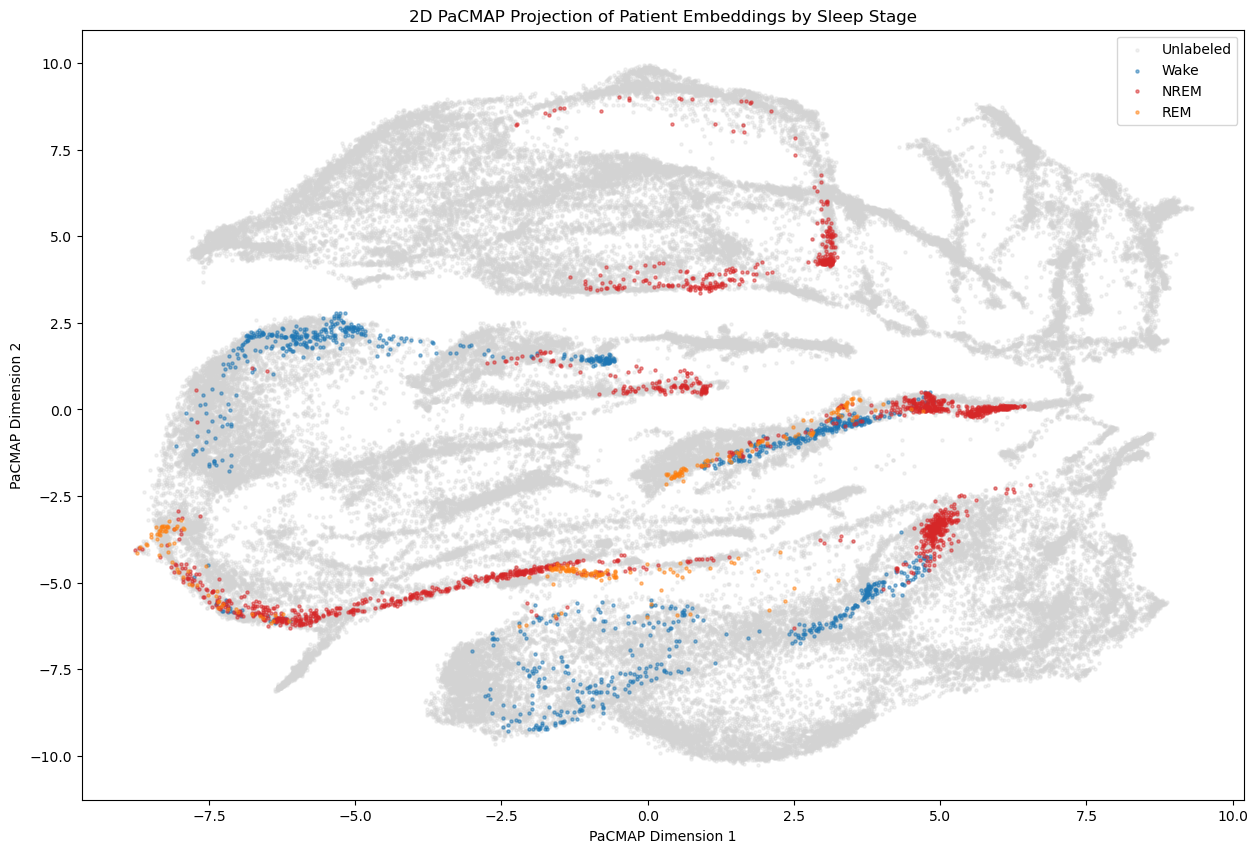

In [43]:
plt.figure(figsize=(15,10))

# Plot unlabeled points in grey first
labeled_mask = np.isin(flat_sleep_labels, ['W', 'N', 'R'])
plt.scatter(manifold_2d[~labeled_mask,0], manifold_2d[~labeled_mask,1],
           c='lightgray', alpha=0.3, s=5, label='Unlabeled')

sleep_colors = {
    'W': '#1f77b4',  # NIZ blue
    'N': '#d62728',  # SOZ red
    'R': '#ff7f0e'   # PZ orange
}
sleep_labels = {
    'W': 'Wake',
    'N': 'NREM',
    'R': 'REM'
}

# Plot labeled points on top
for label in sleep_colors:
    mask = flat_sleep_labels == label
    plt.scatter(manifold_2d[mask,0], manifold_2d[mask,1],
               c=sleep_colors[label],
               label=sleep_labels[label],
               alpha=0.5, s=10)

plt.title('2D PaCMAP Projection of Patient Embeddings by Sleep Stage')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.legend()